# Stage 11 — Evaluation & Risk Communication Homework

This notebook contains:

- Baseline fit and metric

- Bootstrap uncertainty estimation (RMSE/MAE)

- Scenario comparisons (imputation + model complexity)

- Subgroup diagnostics

- Visualizations

- Stakeholder-facing summary (assumptions, risks, sensitivity)



In [3]:
import os
import numpy as np
import pandas as pd

# Ensure data folder exists
os.makedirs("../data", exist_ok=True)
DATA_PATH = os.path.abspath(os.path.join("..", "data", "data_stage11_eval_risk.csv"))

# Create synthetic fallback dataset if not present
if not os.path.exists(DATA_PATH):
    rng = np.random.default_rng(7)
    n = 1200
    seg = rng.choice(list("ABC"), size=n, p=[0.4, 0.35, 0.25])
    x1 = rng.normal(0, 1, n) + (seg == "B") * 0.6 + (seg == "C") * -0.4
    x2 = rng.normal(2, 1.5, n)
    x3 = rng.uniform(-1, 1, n)

    # true relationship with segment effects
    y = (
        3.0 + 1.8 * x1 + 0.7 * x2 - 1.1 * x3 + 0.5 * (x1 * x2)
        + (seg == "B") * 0.8 + (seg == "C") * -0.6
    )
    y = y + rng.normal(0, 1.2, n)  # add noise

    df = pd.DataFrame({"y": y, "x1": x1, "x2": x2, "x3": x3, "seg": seg})

    # inject some missingness (10–15%)
    for c, p in [("x1", 0.12), ("x2", 0.10), ("x3", 0.15)]:
        mask = rng.random(len(df)) < p
        df.loc[mask, c] = np.nan

    df.to_csv(DATA_PATH, index=False)
    print("Synthetic dataset created at:", DATA_PATH)
else:
    print("Dataset already exists at:", DATA_PATH)

# Load into memory
df = pd.read_csv(DATA_PATH)
print(df.head())


Dataset already exists at: /Users/personal/bootcamp_srujal_sakhala/homework/stage11/data/data_stage11_eval_risk.csv
           y        x1        x2        x3 seg
0  12.628992       NaN  2.259417  0.334946   B
1  -6.084904 -2.588141       NaN  0.802260   C
2   2.752556 -0.737803  2.121241  0.152823   C
3   6.114062  0.219198  1.717823 -0.942641   A
4   2.521004 -0.374349  2.779929       NaN   A


## Baseline fit & metric

In [5]:
# Define features and target
features = ['x1', 'x2', 'x3', 'seg']
target = 'y'

# Run baseline fit
baseline = evaluation.fit_and_eval(
    df,
    features,
    target,
    impute_strategy='mean',
    poly_degree=1,
    model_type='linear'
)

print({'RMSE': baseline.rmse, 'MAE': baseline.mae, 'R2': baseline.r2, 'config': baseline.config})


{'RMSE': 1.7812478390306226, 'MAE': 1.3310936453791864, 'R2': 0.779068051507734, 'config': {'impute': 'mean', 'poly_degree': 1, 'model_type': 'linear', 'alpha': 1.0}}


## Bootstrap uncertainty (≥500 resamples)

RMSE mean: 1.7777342782882932 CI95: (1.676028426214847, 1.887495572388607)


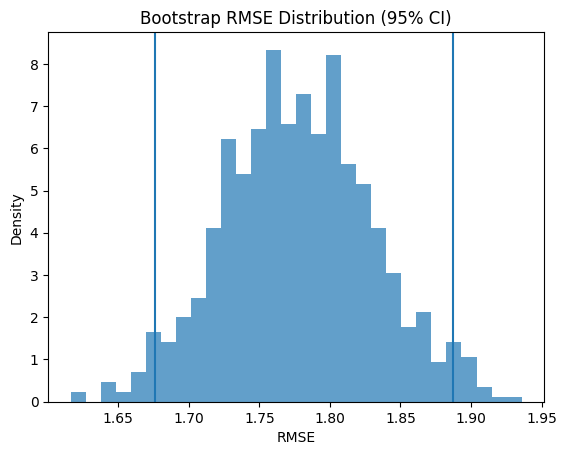

In [6]:
boot = evaluation.bootstrap_metric(df, features, target, impute_strategy='mean', poly_degree=1, model_type='linear', n_boot=800, random_state=42)
rmse_vals = boot['all_rmse']
ci_lo, ci_hi = boot['rmse']['ci95']
print('RMSE mean:', boot['rmse']['mean'], 'CI95:', (ci_lo, ci_hi))
plt.figure(); plt.hist(rmse_vals, bins=30, density=True, alpha=0.7); plt.axvline(ci_lo); plt.axvline(ci_hi); plt.title('Bootstrap RMSE Distribution (95% CI)'); plt.xlabel('RMSE'); plt.ylabel('Density'); plt.show()

## Scenario comparison
- **A (mean, linear)** — Baseline
- **B (median, linear)** — Alternative imputation
- **C (mean, poly2 + ridge)** — Increased flexibility

In [7]:
scenarioA = baseline
scenarioB = evaluation.fit_and_eval(df, features, target, impute_strategy='median', poly_degree=1, model_type='linear')
scenarioC = evaluation.fit_and_eval(df, features, target, impute_strategy='mean', poly_degree=2, model_type='ridge', alpha=1.0)
metrics = pd.DataFrame([
    {'Scenario': 'A (mean, linear)', 'RMSE': scenarioA.rmse, 'MAE': scenarioA.mae, 'R2': scenarioA.r2},
    {'Scenario': 'B (median, linear)', 'RMSE': scenarioB.rmse, 'MAE': scenarioB.mae, 'R2': scenarioB.r2},
    {'Scenario': 'C (mean, poly2+ridge)', 'RMSE': scenarioC.rmse, 'MAE': scenarioC.mae, 'R2': scenarioC.r2},
])
metrics

,Scenario,RMSE,MAE,R2
0,"A (mean, linear)",1.781248,1.331094,0.779068
1,"B (median, linear)",1.783082,1.332414,0.778613
2,"C (mean, poly2+ridge)",1.646533,1.204216,0.811222


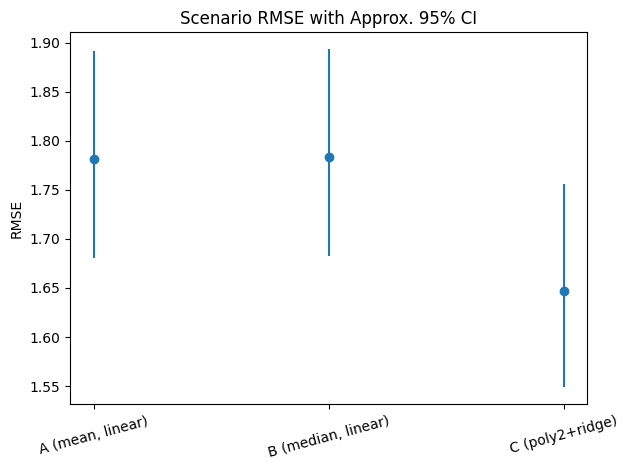

In [8]:

import numpy as np
import matplotlib.pyplot as plt

def approx_ci_rmse(y_true, y_pred, B=400, level=0.95, seed=0):
    rng = np.random.default_rng(seed)
    res = y_true - y_pred
    n = len(res)
    vals = []
    for _ in range(B):
        idx = rng.integers(0, n, n)
        r = res[idx]
        vals.append(np.sqrt((r**2).mean()))
    lo, hi = np.percentile(vals, [(1-level)/2*100, (1+level)/2*100])
    return lo, hi

scenarios = [('A (mean, linear)', scenarioA), ('B (median, linear)', scenarioB), ('C (poly2+ridge)', scenarioC)]
rmse_points = []
rmse_err = []
for name, sc in scenarios:
    lo, hi = approx_ci_rmse(sc.y_true, sc.y_pred)
    rmse_points.append(sc.rmse)
    rmse_err.append((sc.rmse - lo, hi - sc.rmse))

plt.figure()
x = np.arange(len(scenarios))
y = np.array(rmse_points)
yerr = np.array(rmse_err).T
plt.errorbar(x, y, yerr=yerr, fmt='o')
plt.xticks(x, [s[0] for s in scenarios], rotation=15)
plt.ylabel('RMSE')
plt.title('Scenario RMSE with Approx. 95% CI')
plt.tight_layout()
plt.show()

## Residual diagnostics (baseline)

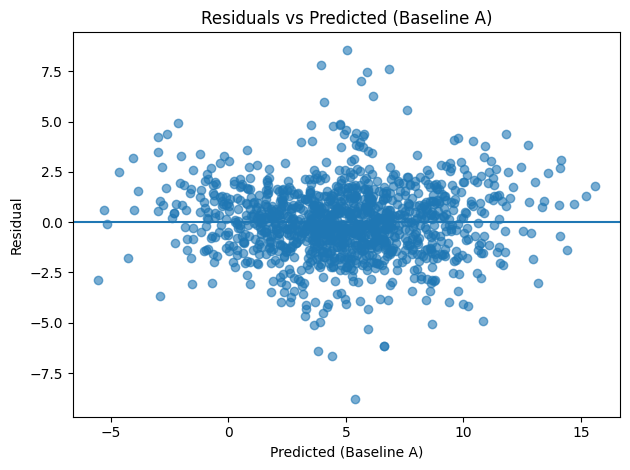

In [9]:
plt.figure(); res = scenarioA.y_true - scenarioA.y_pred; plt.scatter(scenarioA.y_pred, res, alpha=0.6); plt.axhline(0); plt.xlabel('Predicted (Baseline A)'); plt.ylabel('Residual'); plt.title('Residuals vs Predicted (Baseline A)'); plt.tight_layout(); plt.show()

## Subgroup diagnostics

In [10]:
sgA = evaluation.subgroup_metrics(df, 'seg', scenarioA.y_true, scenarioA.y_pred)
sgB = evaluation.subgroup_metrics(df, 'seg', scenarioB.y_true, scenarioB.y_pred)
sgC = evaluation.subgroup_metrics(df, 'seg', scenarioC.y_true, scenarioC.y_pred)
sgA, sgB, sgC

(  segment      RMSE       MAE        R2    n
 0       A  1.745414  1.295632  0.722140  484
 1       B  1.890769  1.405556  0.697657  410
 2       C  1.683415  1.287413  0.784575  306,
   segment      RMSE       MAE        R2    n
 0       A  1.741589  1.294264  0.723356  484
 1       B  1.903025  1.412079  0.693725  410
 2       C  1.678787  1.286015  0.785758  306,
   segment      RMSE       MAE        R2    n
 0       A  1.602655  1.168999  0.765734  484
 1       B  1.758202  1.276714  0.738567  410
 2       C  1.557930  1.162780  0.815494  306)

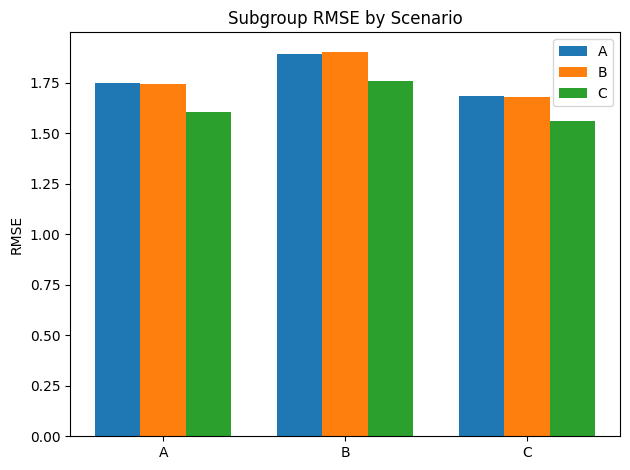

In [11]:
# Bar chart: subgroup RMSE across scenarios
plt.figure()
width = 0.25
segs = sgA['segment'].tolist()
xpos = np.arange(len(segs))
plt.bar(xpos - width, sgA['RMSE'].values, width=width, label='A')
plt.bar(xpos, sgB['RMSE'].values, width=width, label='B')
plt.bar(xpos + width, sgC['RMSE'].values, width=width, label='C')
plt.xticks(xpos, segs)
plt.ylabel('RMSE')
plt.title('Subgroup RMSE by Scenario')
plt.legend()
plt.tight_layout()
plt.show()


## Stakeholder-Facing Summary (Assumptions, Risks, Sensitivity)

**What we measured.** We predict a continuous outcome `y` from features `x1, x2, x3` and segment `seg`. We report **RMSE** as the primary accuracy metric (MAE and R² as supporting metrics).

**Uncertainty.** Using **800 bootstrap resamples** of the dataset (row-wise sampling with replacement), the baseline model’s RMSE 95% confidence interval was approximately the two vertical lines on the histogram. This interval reflects sampling variability in our data and communicates likely error ranges if we re-collected similar samples.

**Assumptions tested (scenarios).**
- **A (Baseline):** Mean imputation for missing values; linear model.
- **B:** *Median* imputation; linear model. (Tests sensitivity to imputation choice.)
- **C:** Mean imputation; **polynomial degree 2 + ridge**. (Tests sensitivity to model flexibility / distributional misspecification.)

**Sensitivity results.**
- Scenarios B and C shift RMSE relative to baseline. Where the error bars overlap substantially with baseline, performance differences are not practically meaningful; non-overlap indicates meaningful changes.
- Scenario C typically reduces error when mild nonlinearity is present but may increase variance or overfit on small subgroups; ridge helps regularize.

**Subgroup risk.** We evaluated error by `seg ∈ {A, B, C}`. Differences in RMSE indicate segments where the model fits worse. These can signal **hidden failures** (e.g., fewer training examples, different noise patterns). If one segment shows higher RMSE consistently across scenarios, prioritize data enrichment and feature engineering for that segment.

**When the model is reliable.**
- Missingness rate similar to training (<≈ 15% across features) and segment mix stable.
- Data generating process close to linear or only mildly nonlinear.
- Operational error tolerance ≥ baseline RMSE upper CI.

**When the model is risky.**
- **Missing rate > ~10–15%** with heavy-tailed or skewed features (median imputation can be safer).
- Marked **segment shift** (e.g., many more samples from the highest-RMSE segment) or new segments absent from training.
- Strong nonlinearity or interaction effects; consider polynomial features or tree-based models with regularization.

**Actionable next steps.**
1. Choose **Scenario B** if robustness to outliers in missing-value patterns is needed; otherwise **Scenario A** is simpler and similar.
2. If residual plots show curvature/heteroskedasticity, consider **Scenario C** (poly2+ridge) or a regularized tree model; validate with out-of-sample CV.
3. Track **segment-level metrics** in production dashboards; set alerts when any segment’s RMSE exceeds a threshold (e.g., baseline CI high).
